In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
credit = pd.read_csv('credit_card_default_analysis.csv', sep = ",", header = 0)
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
credit_returned_true = credit[credit['default'] == 0].drop(['default'], axis = 1)
credit_returned_false = credit[credit['default'] == 1].drop(['default'], axis = 1)

## Task 1

Построим график размера кредита в каждой из двух групп 

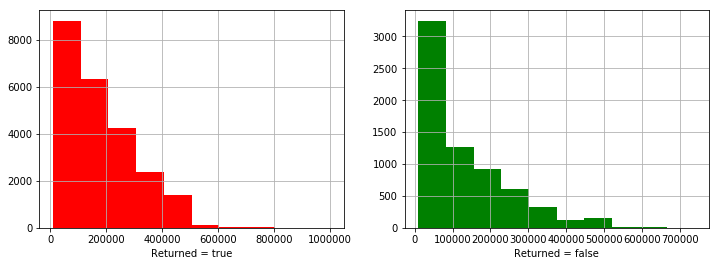

In [5]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_returned_true['LIMIT_BAL'], color = 'r')
pylab.xlabel('Returned = true')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_returned_false['LIMIT_BAL'], color = 'g')
pylab.xlabel('Returned = false')

pylab.show()

Проверим нормальность распределений

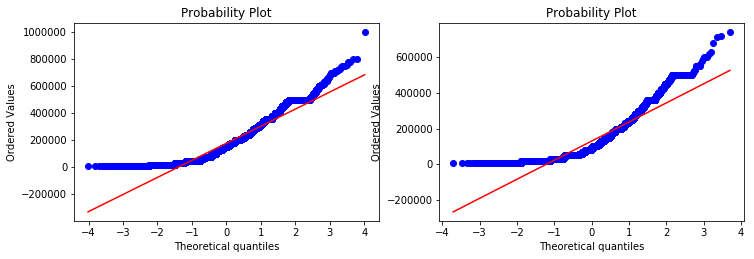

In [6]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(credit_returned_true['LIMIT_BAL'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(credit_returned_false['LIMIT_BAL'], dist="norm", plot=plt)
plt.show()

In [7]:
print "Тест Шапиро-Уилка для группы вернувших кредит: ", stats.shapiro(credit_returned_true['LIMIT_BAL'])
print "Тест Шапиро-Уилка для группы не вернувших кредит: ", stats.shapiro(credit_returned_false['LIMIT_BAL'])

Тест Шапиро-Уилка для группы вернувших кредит:  (0.9197262525558472, 0.0)
Тест Шапиро-Уилка для группы не вернувших кредит:  (0.8549829721450806, 0.0)


/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Как видим распределения не нормальные. Посчитаем доверительные интервалы методом бутстреп

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) 
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
values_returned_true = credit_returned_true['LIMIT_BAL'].values
values_returned_false = credit_returned_false['LIMIT_BAL'].values

np.random.seed(0)

median_scores_returned_true = map(np.median, get_bootstrap_samples(values_returned_true, 5000))
median_scores_returned_false = map(np.median, get_bootstrap_samples(values_returned_false, 5000))

print 'доверительный интервал для вернувших кредит: ',  stat_intervals(median_scores_returned_true, 0.05)
print 'доверительный интервал для не вернувших кредит: ',  stat_intervals(median_scores_returned_false, 0.05)

доверительный интервал для вернувших кредит:  [150000. 150000.]
доверительный интервал для не вернувших кредит:  [80000. 90000.]


In [11]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(median_scores_returned_true,
                                                     median_scores_returned_false))
print 'доверительный интервал для разницы медиан: ',  stat_intervals(delta_median_scores, 0.05)

доверительный интервал для разницы медиан:  [-70000. -60000.]


In [12]:
stats.mannwhitneyu(credit_returned_true['LIMIT_BAL'], credit_returned_false['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

**Вывод**: среднее значение размера кредитного лимита выше у тех, кто в итоге вернул кредит. И критерий Манна-Уитни опровергает гипотезу о том что средние одинаковые. Результаты значимы с практической точки зрения, т.к говорят о том что первых можно отделить от вторых.

Посчитаем размер эффекта

In [13]:
print float( credit_returned_false['LIMIT_BAL'].median()) / \
 float(credit_returned_true['LIMIT_BAL'].median()) * 100 , '%'

60.0 %


## Task 2

Построим график возвратов кредита. Разбьем по полам

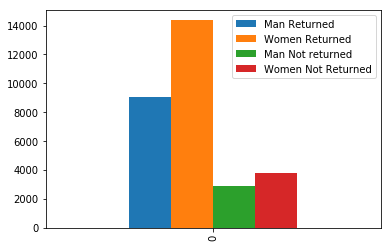

In [14]:
returned = credit['SEX'][credit['default'] == 0] - 1
not_returned = credit['SEX'][credit['default'] == 1] - 1

gender_stat = pd.DataFrame([[len(returned) - sum(returned),
                          sum(returned),
                          len(not_returned) - sum(not_returned),
                          sum(not_returned)]], 
                      columns = ["Man Returned", "Women Returned", "Man Not returned", "Women Not Returned"])

pylab.figure(figsize=(12,4))
gender_stat.plot.bar()
pylab.show()

Построим доверительный интервал

In [15]:
conf_interval_returned_true = proportion_confint(sum(credit_returned_true['SEX']-1), 
                                            len(credit_returned_true['SEX']),
                                            method = 'wilson')
conf_interval_returned_false = proportion_confint(sum(credit_returned_false['SEX']-1), 
                                            len(credit_returned_false['SEX']),
                                            method = 'wilson')
print '95%% confidence interval for the mean (Returned): [%f, %f]' % conf_interval_returned_true
print '95%% confidence interval for the mean (Not Returned): [%f, %f]' % conf_interval_returned_false


95% confidence interval for the mean (Returned): [0.607890, 0.620373]
95% confidence interval for the mean (Not Returned): [0.555102, 0.578938]


Посчитаем доверительный интервал для разницы долей

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

print "95%% доверительный интервал для разности долей: [%f, %f]" % proportions_diff_confint_ind(credit_returned_true['SEX']-1, credit_returned_false['SEX']-1)

95% доверительный интервал для разности долей: [0.033635, 0.060548]


Посчитаем уровень значимости

In [17]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(credit_returned_true['SEX']-1, 
                                                                              credit_returned_false['SEX']-1))

p-value: 0.000000


**Вывод:** из того что доверительные интервалы не пересекаются и того, что p-value очень низкий, делаем вывод что гендерный состав отличается (женщины более исправно выплачивают кредит).

## Task 3

Визуализируем процент невозвращенных кредитов в зависимости от образования

In [20]:
perc = []
credit_mean = float(sum(credit['default']))/len(credit['default'])
for i in range(0,7):
    perc.append(float(sum(credit[credit['EDUCATION'] ==  i]['default']))/ \
                len(credit[credit['EDUCATION'] ==  i]['default']))
noreturns_percent = pd.DataFrame([perc],columns=['доктор','магистр','бакалавр','выпускник школы','начальное образование',
                                                 'прочее','нет данных'])
noreturns_percent

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных
0,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863


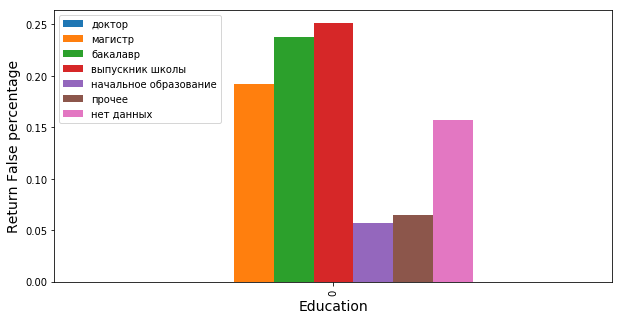

In [21]:
plt.figure(figsize(10,5))
noreturns_percent.plot.bar()
plt.xlabel('Education', fontsize=14)
plt.ylabel('Return False percentage', fontsize=14)
pylab.show()

Построим таблицу сопряженности

In [22]:
contingency_table = pd.crosstab(credit['EDUCATION'], credit['default'])
contingency_table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Т.к у нас значения категориальные, можно попробовать посчитать коэфициент корреляции Крамера и p-value для гипотезы о независимости параметров. 

In [23]:
def v_cramer(contingency_table):
    chi2, p, dof, ex = scipy.stats.chi2_contingency(contingency_table)
    n = sum(sum(contingency_table))
    return np.sqrt(chi2 / (n*(min(shape(contingency_table))-1))), p, dof, ex 

FC, pvalue, dof, ex = v_cramer(contingency_table)
print 'Коэф-т Крамера: %f:' % FC 
print 'p-value: %f:' %pvalue


Коэф-т Крамера: 0.073760:
p-value: 0.000000:


Поверим, проверим правомерны ли мы использовать критерий хи-квадрат. Выборка достаточно большая, n > 40, тут все ок. Посмотрим на таблицу ожидаемых значений

In [24]:
expected_values = pd.DataFrame(ex)
expected_values

,0,1
0,10.9032,3.0968
1,8243.5980,2341.4020
2,10926.5640,3103.4360
3,3829.3596,1087.6404
4,95.7924,27.2076
5,218.0640,61.9360
6,39.7188,11.2812


Почти в о всех ячейках кол-во элементов > 5. так что мы были вправе использовать критерий хи-квадрат

Визуализируем разницу между фактическими и ожидаемыми значениями таблицы сопряженности

In [25]:
diff = pd.DataFrame(contingency_table[0] - expected_values[0])
diff

,0
EDUCATION,
0,3.0968
1,305.4020
2,-226.5640
3,-149.3596
4,20.2076
5,43.9360
6,3.2812


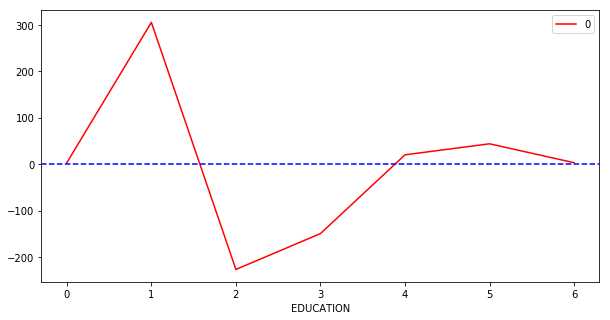

In [26]:
diff.plot(color='r')
plt.axhline(y=0, color='b', linestyle='--')
plt.show()

In [27]:
diff['Normed Diff 0'] = diff[0]/expected_values[0]
diff['Normed Diff 1'] = diff[0]/expected_values[1]
diff.head()

,0,Normed Diff 0,Normed Diff 1
EDUCATION,,,
0,3.0968,0.284027,1.000000
1,305.4020,0.037047,0.130436
2,-226.5640,-0.020735,-0.073004
3,-149.3596,-0.039004,-0.137324
4,20.2076,0.210952,0.742719


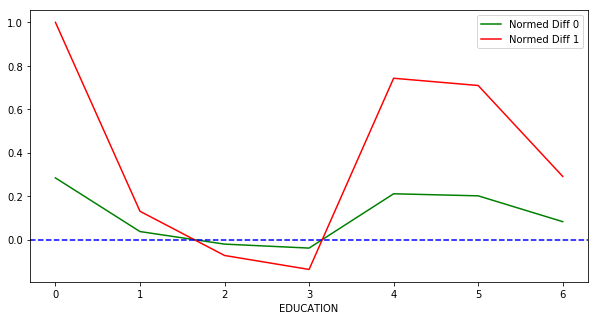

In [28]:
diff.iloc[:,1].plot(color='g')
diff.iloc[:,2].plot(color='r')
plt.axhline(y=0, color='b', linestyle='--')
plt.legend()
plt.show()

Видим что наименьшая степень отклонения (нормированая) ожидаемых значений от фактических получаем для групп 'магистр', 'бакалавр', 'выпускник школы'

**Выводы:** 

Вопрос: Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?<br>
Ответ: как показано в таблице выше - нормированное значение разниц фактических значений от предсказанных<br><br>
Вопрос: Наличие какого образования является наилучшим индикатором того, что человек отдаст долг?<br>
Ответ: Доктор<br><br>
Вопрос: наоборт, не отдаст долг?<br>
Ответ: Выпускник школы<br>

## Task 4

Визуализируем данные - построим график процента невозврата для каждой группы и таблицу сопряженности

In [29]:
perc = []
credit_mean = float(sum(credit['default']))/len(credit['default'])
for i in range(0,4):
    perc.append(float(sum(credit[credit['MARRIAGE'] ==  i]['default']))/ \
                len(credit[credit['MARRIAGE'] ==  i]['default']))

#len(perc)
noreturns_percent = pd.DataFrame([perc],columns=['отказываюсь отвечать','замужем/женат','холост','нет данных'])
noreturns_percent

,отказываюсь отвечать,замужем/женат,холост,нет данных
0,0.092593,0.234717,0.209283,0.260062


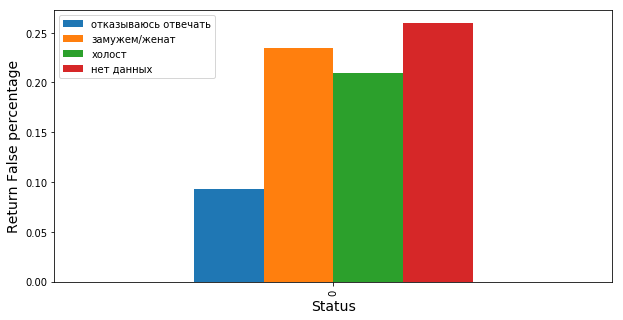

In [30]:
plt.figure(figsize(10,5))
noreturns_percent.plot.bar()
plt.xlabel('Status', fontsize=14)
plt.ylabel('Return False percentage', fontsize=14)
pylab.show()

Построим таблицу сопряженности для двух групп - женатых и холостых

In [32]:
contingency_table_marriage = pd.crosstab(credit['MARRIAGE'], credit['default'])
contingency_table_marriage = contingency_table_marriage.drop([0], axis = 0)
contingency_table_marriage = contingency_table_marriage.drop([3], axis = 0)

contingency_table_marriage

default,0,1
MARRIAGE,,
1,10453,3206
2,12623,3341


Т.к у нас значения категориальные, можно попробовать посчитать коэфициент корреляции Крамера и p-value для гипотезы о независимости параметров. 

In [95]:
FC, pvalue, dof, ex = v_cramer(contingency_table_marriage)
print 'Коэф-т Крамера: %f' % FC
print 'p-value: %f' % pvalue

Коэф-т Крамера: 0.030474
p-value: 0.000000


Поверим, проверим правомерны ли мы использовать критерий хи-квадрат. Выборка достаточно большая, n > 40, тут все ок. Посмотрим на таблицу ожидаемых значений

In [33]:
expected_values = pd.DataFrame(ex)
expected_values

,0,1
0,10.9032,3.0968
1,8243.5980,2341.4020
2,10926.5640,3103.4360
3,3829.3596,1087.6404
4,95.7924,27.2076
5,218.0640,61.9360
6,39.7188,11.2812


Во всех ячейках кол-во элементов > 5. так что мы были вправе использовать критерий хи-квадрат

**Ответ:** процент вылачиваемых кредитов у женатых и холостых отличается, хот и крайне слабо, т.к коэф-т Крамера очень низкий.

## Task 5

Визуализируем данные. Покажем разброс по возрасту для каждой из групп (вернувших и не вернувших)

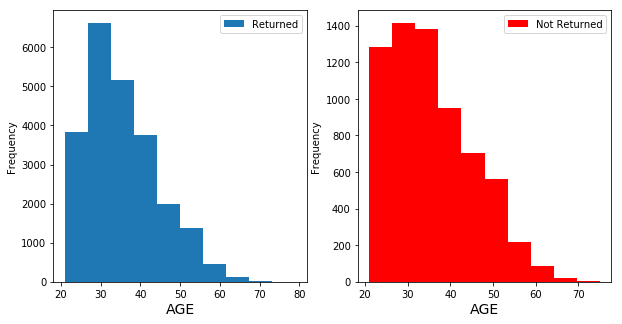

In [34]:
plt.figure(figsize(10,5))

plt.subplot(121)
credit[credit['default'] ==  0]['AGE'].plot.hist(label = "Returned")
plt.xlabel('AGE', fontsize=14)
pylab.legend()

plt.subplot(122)
credit[credit['default'] ==  1]['AGE'].plot.hist(label = "Not Returned", color = 'r')
plt.xlabel('AGE', fontsize=14)
pylab.legend()

pylab.show()

In [35]:
returned = credit[credit['default'] ==  0]['AGE']
not_returned = credit[credit['default'] ==  1]['AGE']

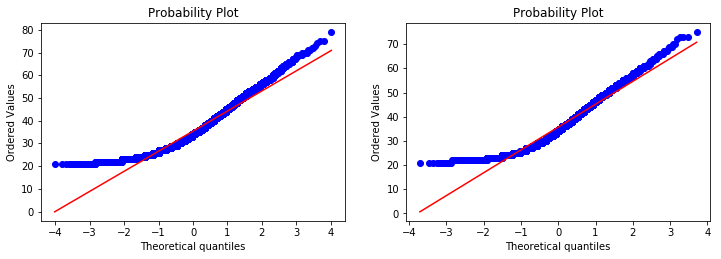

In [37]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(credit_returned_true['AGE'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(credit_returned_false['AGE'], dist="norm", plot=plt)
plt.show()

In [39]:
print "Тест Шапиро-Уилка для группы вернувших кредит: ", stats.shapiro(credit_returned_true['AGE'])
print "Тест Шапиро-Уилка для группы не вернувших кредит: ", stats.shapiro(credit_returned_false['AGE'])

Тест Шапиро-Уилка для группы вернувших кредит:  (0.9496142864227295, 0.0)
Тест Шапиро-Уилка для группы не вернувших кредит:  (0.9501640200614929, 1.0733946236728099e-42)


Как видим распределения не нормальные. Посчитаем доверительные интервалы методом бутстреп

In [40]:
values_returned_true = credit_returned_true['AGE'].values
values_returned_false = credit_returned_false['AGE'].values

np.random.seed(0)

median_scores_returned_true = map(np.median, get_bootstrap_samples(values_returned_true, 5000))
median_scores_returned_false = map(np.median, get_bootstrap_samples(values_returned_false, 5000))

print 'доверительный интервал для вернувших кредит: ',  stat_intervals(median_scores_returned_true, 0.05)
print 'доверительный интервал для не вернувших кредит: ',  stat_intervals(median_scores_returned_false, 0.05)

доверительный интервал для вернувших кредит:  [34. 34.]
доверительный интервал для не вернувших кредит:  [34. 35.]


Интервалы пересекаются. 
Посчитаем доверительный интервал для разницы медиан

In [41]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(median_scores_returned_true,
                                                     median_scores_returned_false))
print 'доверительный интервал для разницы медиан: ',  stat_intervals(delta_median_scores, 0.05)

доверительный интервал для разницы медиан:  [0. 1.]


Т.к распределения не нормальные, для оценки среднего используем непараметрическую оценку критерием Манна-Уитни

In [42]:
stats.mannwhitneyu(credit_returned_true['AGE'], credit_returned_false['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

In [43]:
print float( credit_returned_false['AGE'].median()) / \
 float(credit_returned_true['AGE'].median()) * 100 , '%'

100.0 %


Выводы: <br>
a) о равенстве медианных значений возрастов людей <br>
Ответ: Доверительные интервалы медиан пересекаются, то есть нельзя утверждать что они отличаются<br><br>
b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?<br>
Ответ: нельзя утверждать что распределения возрастов отличаются, pvalue=0.18625 не позволяет отклонить гипотезу. Также медианные значения не отличаются. Полученные результаты медиан практически не значимы.